In [1]:
import torch
print(torch.version.cuda)
print(torch.cuda.is_available())


11.7
True


In [ ]:
# Create a MPS device
# device = torch.device("mps")
# device

In [2]:
use_cuda=torch.cuda.is_available()
device=torch.device('cuda:0' if use_cuda else 'cpu')

In [ ]:
! pip install SentencePiece


In [ ]:
! pip install langid

In [ ]:
! pip install unidecode

In [ ]:
! pip install transformers


In [ ]:
! pip install pandas

In [ ]:
! pip install -U matplotlib

In [ ]:
! pip install wandb

In [3]:
! wandb login 0cf8d63ac20cff538d748e7412a8d60561ff1268

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\priya/.netrc


In [ ]:
! pip install -U scikit-learn

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader,random_split,RandomSampler, SequentialSampler
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup,GPT2Config
import pandas as pd
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
from IPython import display
plt.rcParams["figure.figsize"] = 8, 6
import wandb
import re
from collections import Counter

import unidecode
import langid
import random
from sklearn.model_selection import ParameterGrid
import torch.optim as optim


In [4]:
full_dataset =pd.read_csv('../dataset/all_quotes.csv',low_memory=False)
full_dataset=full_dataset.head(500) #For testing purpose only
print(full_dataset.shape)


(500, 5)


In [5]:
full_dataset.head()

,Unnamed: 0,quotes,author,tag,other_tags
0,0,“Control of consciousness determines the quali...,"― Mihaly Csikszentmihalyi, Flow: The Psycholog...",happiness,"[' consciousness, happiness, quality-of-life']"
1,1,“Copulation is no more foul to me than death is.”,"― Walt Whitman, Leaves of Grass: The First (18...",death,"[' death, sex']"
2,2,“Hope is a dream of which we long to have. Don...,"― Peace Gypsy, Souls Deep",happiness,"[' dreamers, dreams, happiness, love, peace']"
3,3,“True devotion and humility is when you carele...,― Michael Bassey Johnson,truth,"[' acceptance, achilles-heel, admiration, affe..."
4,4,"“Truths are written, never said... Lines are d...","― Colleen Hoover, Maybe Someday",poetry,"[' love, maybe-someday, poetry, ridge-lawson']"


In [6]:
new_dataset = full_dataset[['quotes', 'tag']]
new_dataset = new_dataset[new_dataset['quotes'].apply(lambda x: unidecode.unidecode(x).isascii())]

# Set the seed for reproducibility
random.seed(123)

# Define a function to detect the language of a string
def detect_language(text):
    return langid.classify(text)[0]

# Add a new column to the DataFrame with the language of each quote
new_dataset['language'] = new_dataset['quotes'].apply(detect_language)

# Filter the DataFrame to keep only the rows where the language is English
new_dataset = new_dataset[new_dataset['language'] == 'en']

# Drop the language column from the DataFrame
new_dataset = new_dataset.drop('language', axis=1)
new_dataset = new_dataset.reset_index(drop=True)
print(new_dataset.shape)

(483, 2)


           tag  count
0    happiness     61
9         time     55
8      success     53
2        truth     52
1        death     47
4  inspiration     47
3       poetry     45
7      science     43
6         love     41
5      romance     39


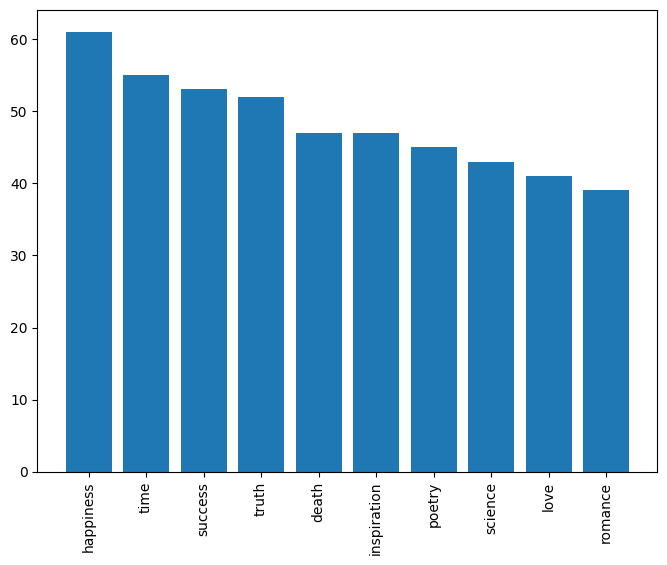

In [7]:
# Lowercase the text
# full_dataset['tags'] = full_dataset['tags'].apply(lambda x: x.lower())
tag_string = ','.join(new_dataset['tag'])
tag_list = [tag.strip() for tag in tag_string.split(',')] # all tags in this list
tag_counts = Counter(tag_list)
tag_df = pd.DataFrame({'tag': tag_counts.keys(), 'count': tag_counts.values()})
tag_df = tag_df.sort_values(by='count', ascending=False)
print(tag_df)
plt.bar(tag_df['tag'][:50], tag_df['count'][:50])
plt.xticks(rotation=90)
plt.show()

In [8]:
new_dataset['quotes'] = new_dataset['quotes'].str.replace('“', '')
new_dataset['quotes'] = new_dataset['quotes'].str.replace('”', '')

In [9]:
#Data preprocessing
# Remove new line
new_dataset['quotes'] = new_dataset['quotes'].apply(lambda x: re.sub(r'\n+', ' ', x))

# Lowercase the text
new_dataset['quotes'] = new_dataset['quotes'].apply(lambda x: x.lower())

In [10]:
def plot_word_distribution(sentences):
    # Initialize a dictionary to keep track of the count of sentences in each bin
    bin_counts = {'0-100': 0, '100-200': 0, '200-300': 0, '300-400': 0, '400-500': 0, '500-600': 0, '600+': 0}
    sentence_lengths = []
    
    for sentence in sentences:
        # Get the length of the sentence in words
        length = len(sentence.split())
        sentence_lengths.append(length)
        
        # Update the count of sentences in the appropriate bin
        if length <= 100:
            bin_counts['0-100'] += 1
        elif length <= 200:
            bin_counts['100-200'] += 1
        elif length <= 300:
            bin_counts['200-300'] += 1
        elif length <= 400:
            bin_counts['300-400'] += 1
        elif length <= 500:
            bin_counts['400-500'] += 1
        elif length <= 600:
            bin_counts['500-600'] += 1
        else:
            bin_counts['600+'] += 1   
    # Print the counts of sentences in each bin
    print(f"Sentences with 0-100 words: {bin_counts['0-100']}")
    print(f"Sentences with 100-200 words: {bin_counts['100-200']}")
    print(f"Sentences with 200-300 words: {bin_counts['200-300']}")
    print(f"Sentences with 300-400 words: {bin_counts['300-400']}")
    print(f"Sentences with 400-500 words: {bin_counts['400-500']}")
    print(f"Sentences with 500-600 words: {bin_counts['500-600']}")
    print(f"Sentences with 600+ words: {bin_counts['600+']}")

plot_word_distribution(new_dataset['quotes'])


Sentences with 0-100 words: 458
Sentences with 100-200 words: 22
Sentences with 200-300 words: 3
Sentences with 300-400 words: 0
Sentences with 400-500 words: 0
Sentences with 500-600 words: 0
Sentences with 600+ words: 0


In [11]:
def max_words_sentence(sentences):
    sentence_lengths = [len(s.split()) for s in sentences]
    max_length = max(sentence_lengths)
    max_sentence = sentences[sentence_lengths.index(max_length)]
    return max_sentence, max_length
max_words_sentence(new_dataset['quotes'])

("you think because he doesn't love you that you are worthless. you think that because he doesn't want you anymore that he is right -- that his judgement and opinion of you are correct. if he throws you out, then you are garbage. you think he belongs to you because you want to belong to him. don't. it's a bad word, 'belong.' especially when you put it with somebody you love. love shouldn't be like that. did you ever see the way the clouds love a mountain? they circle all around it; sometimes you can't even see the mountain for the clouds. but you know what? you go up top and what do you see? his head. the clouds never cover the head. his head pokes through, beacuse the clouds let him; they don't wrap him up. they let him keep his head up high, free, with nothing to hide him or bind him. you can't own a human being. you can't lose what you don't own. suppose you did own him. could you really love somebody who was absolutely nobody without you? you really want somebody like that? somebod

In [12]:
max_length_value=768

In [13]:
class QuotesDataset(Dataset):
    def __init__(self, quotes, tokenizer,max_length_value):
        self.input_ids = []
        self.attn_masks = []
        self.tokenizer = tokenizer

        for quote in quotes:
          encodings_dict = tokenizer("<|startoftext|>"+quote+"<|endoftext|>",
                                    truncation=True,
                                    max_length=max_length_value,
                                    padding="max_length") #We are using max length padding
          
          self.input_ids.append(torch.tensor(encodings_dict["input_ids"]))
          self.attn_masks.append(torch.tensor(encodings_dict["attention_mask"]))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx]

In [14]:
#Hyper parameters

all_hyper_parameters= {
    "batch_size":[4],
    "lr":[2e-5,1e-3],
    "optimizer":['Adagrad','AdamW'],
    "warmup_steps":[800],
    "num_epochs": [20],
    "dropout":[0],
    }
# all_hyper_parameters= {
#     "batch_size":[4],
#     "lr":[1e-1],
#     "optimizer":['AdamW'],
#     "warmup_steps":[100,500],
#     "num_epochs": [ 2],
#     "dropout":[0.25],
#     }

In [15]:
#Add the tags with the quotes for training
new_dataset['tag_quotes'] = new_dataset.apply(lambda x: x['tag'] + ':' + x['quotes'], axis=1)
print(new_dataset['tag_quotes'].head())

0    happiness:control of consciousness determines ...
1    death:copulation is no more foul to me than de...
2    happiness:hope is a dream of which we long to ...
3    truth:true devotion and humility is when you c...
4    poetry:truths are written, never said... lines...
Name: tag_quotes, dtype: object


In [16]:
quotes = new_dataset['tag_quotes']
train_size = int(0.8*len(quotes))
val_size = len(quotes) - train_size
print(train_size,val_size)
train_dataset, val_dataset = random_split(quotes, [train_size, val_size])


386 97


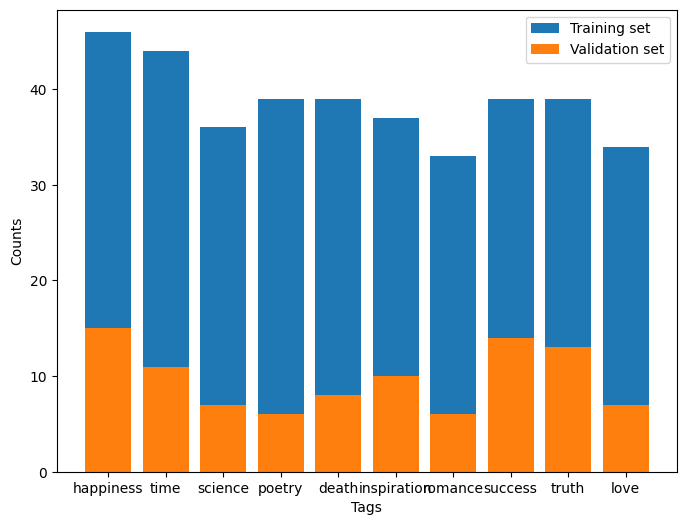

In [17]:
train_tags = [item.split(":")[0] for item in train_dataset]
val_tags =[item.split(":")[0] for item in val_dataset]

# Count the number of occurrences of each tag in each list
train_tag_counts = Counter(train_tags)
val_tag_counts = Counter(val_tags)

# Plot the tag distributions
fig, ax = plt.subplots()
ax.bar(train_tag_counts.keys(), train_tag_counts.values(), label='Training set')
ax.bar(val_tag_counts.keys(), val_tag_counts.values(), label='Validation set')
ax.set_xlabel('Tags')
ax.set_ylabel('Counts')
ax.legend()
plt.show()

In [18]:

tokenizer = GPT2Tokenizer.from_pretrained('gpt2', 
                                          bos_token='<|startoftext|>', 
                                          eos_token='<|endoftext|>', 
                                          pad_token='<|pad|>')


train_tokenized_dataset=QuotesDataset(train_dataset, tokenizer,max_length_value)
val_tokenized_dataset=QuotesDataset(val_dataset, tokenizer,max_length_value)

grid=ParameterGrid(all_hyper_parameters)
loss_values=[]
combination=0
for hyper_param in grid: 
    combination=combination+1
    print(f'combination {combination} ,num_epochs: {hyper_param["num_epochs"]} ,batch_size: {hyper_param["batch_size"]} ,learning_rate: {hyper_param["lr"]} ,optimizer: {hyper_param["optimizer"]} ,warm_up_step: {hyper_param["warmup_steps"]}, Dropout: {hyper_param["dropout"]}')
    train_dataloader = DataLoader(train_tokenized_dataset,
                                sampler=RandomSampler(train_tokenized_dataset),
                                batch_size=hyper_param['batch_size'])

    val_dataloader = DataLoader(val_tokenized_dataset,
                                sampler=SequentialSampler(val_tokenized_dataset),
                                batch_size=hyper_param['batch_size'])
    wandb.init(
        project="quotes-generator-project-3",
        config={
        "learning_rate":hyper_param["lr"], 
        "batch_size":hyper_param["batch_size"],
        "warmup_steps":hyper_param["warmup_steps"],
        "optimizer":hyper_param["optimizer"],
        "num_epochs":hyper_param["num_epochs"],
        "dropout":hyper_param["dropout"],
        }
    )

    # Load model configuration
    config = GPT2Config.from_pretrained("gpt2")
    config.dropout=hyper_param['dropout']
    # Create model instance and set embedding length
    model = GPT2LMHeadModel.from_pretrained("gpt2", config=config)
    model.resize_token_embeddings(len(tokenizer))

    # Running the model on GPU
    model = model.to(device)
    if hyper_param['optimizer']=='AdamW':
        optimizer = AdamW(model.parameters(), lr=hyper_param['lr'], eps=1e-8)
    else:
        optimizer = optim.Adagrad(model.parameters(), lr=hyper_param['lr'])


    # Toatl training steps is the number of data points times the number of epochs
    total_training_steps = len(train_dataloader)*hyper_param['num_epochs']

    # Setting a variable learning rate using scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=hyper_param['warmup_steps'],
                                                num_training_steps=total_training_steps)
    training_stats = []
    all_training_loss=[]
    all_valid_loss=[]
    for epoch_i in range(hyper_param['num_epochs']):
        print(f"Beginning epoch {epoch_i+1} of {hyper_param['num_epochs']}")
        total_train_loss = 0
        model.train()

        # Labels are shifted by 1 timestep
        for step, batch in enumerate(train_dataloader):
            b_input_ids = batch[0].to(device)
            b_labels = batch[0].to(device)
            b_masks = batch[1].to(device)

            model.zero_grad()

            outputs = model(b_input_ids,
                            labels=b_labels,
                            attention_mask=b_masks)
            
            loss = outputs[0]
            wandb.log({"Training Loss": loss})

            batch_loss = loss.item()
            total_train_loss += batch_loss
            loss.backward()
            optimizer.step()
            scheduler.step()

        all_training_loss.append(total_train_loss)
        avg_train_loss = total_train_loss / len(train_dataloader)
        print(f'Average Training Loss: {avg_train_loss}.')
        
        model.eval()

        total_eval_loss = 0
        nb_eval_steps = 0

        for batch in val_dataloader:
            b_input_ids = batch[0].to(device)
            b_labels = batch[0].to(device)
            b_masks = batch[1].to(device)
                
            with torch.no_grad():        

                outputs  = model(b_input_ids,  
                                attention_mask = b_masks,
                                labels=b_labels)
                
                loss = outputs[0]  
                wandb.log({"Validation Loss": loss})

            batch_loss = loss.item()
            total_eval_loss += batch_loss   

        all_valid_loss.append(total_eval_loss)
        avg_val_loss = total_eval_loss / len(val_dataloader) 
        print(f'Validation loss: {avg_val_loss}.')
    hyper_dict = {
        "hyperparameters": f'num_epochs: {hyper_param["num_epochs"]} batch_size: {hyper_param["batch_size"]} learning_rate: {hyper_param["lr"]} optimizer: {hyper_param["optimizer"]} warm_up_step: {hyper_param["warmup_steps"]} dropout: {hyper_param["dropout"]}',
        "train_loss": all_training_loss,
        "val_loss": all_valid_loss}
    loss_values.append(hyper_dict)
wandb.finish()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


combination 1 ,num_epochs: 20 ,batch_size: 4 ,learning_rate: 2e-05 ,optimizer: Adagrad ,warm_up_step: 800, Dropout: 0


wandb: Currently logged in as: pkirupaharan (quotes). Use `wandb login --relogin` to force relogin


Beginning epoch 1 of 20
Average Training Loss: 6.238447243405371.
Validation loss: 4.216724071502686.
Beginning epoch 2 of 20
Average Training Loss: 5.554880980363826.
Validation loss: 3.874363660812378.
Beginning epoch 3 of 20
Average Training Loss: 5.1872227585192805.
Validation loss: 3.6643341636657714.
Beginning epoch 4 of 20
Average Training Loss: 4.707629164469611.
Validation loss: 3.3737621974945067.
Beginning epoch 5 of 20
Average Training Loss: 4.083641495901285.
Validation loss: 2.968751406669617.
Beginning epoch 6 of 20
Average Training Loss: 3.2942524718255113.
Validation loss: 2.389600577354431.
Beginning epoch 7 of 20
Average Training Loss: 2.1475781583294427.
Validation loss: 1.7321226572990418.
Beginning epoch 8 of 20
Average Training Loss: 1.3480345422459632.
Validation loss: 1.242103726863861.
Beginning epoch 9 of 20
Average Training Loss: 0.9651149111924712.
Validation loss: 0.9428675127029419.
Beginning epoch 10 of 20
Average Training Loss: 0.8165437121366718.
Valid

Training Loss,▆▅▇▄▅▆▂█▇▄▄▄▂▃▂▂▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
Validation Loss,▇▅▅▄█▄▃▅▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
Training Loss,0.36578
Validation Loss,0.31025


c:\Users\priya\anaconda3\envs\my_env_2\lib\site-packages\transformers\optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Beginning epoch 1 of 20
Average Training Loss: 10.120947410150901.
Validation loss: 5.724827537536621.
Beginning epoch 2 of 20
Average Training Loss: 3.2496194630554043.
Validation loss: 1.2543818402290343.
Beginning epoch 3 of 20
Average Training Loss: 0.8057240140192288.
Validation loss: 0.44362505197525026.
Beginning epoch 4 of 20
Average Training Loss: 0.47156131390443784.
Validation loss: 0.32303239464759825.
Beginning epoch 5 of 20
Average Training Loss: 0.3735508087676825.
Validation loss: 0.2730629110336304.
Beginning epoch 6 of 20
Average Training Loss: 0.32358479499816895.
Validation loss: 0.23669508695602418.
Beginning epoch 7 of 20
Average Training Loss: 0.2944129529533927.
Validation loss: 0.22035897076129912.
Beginning epoch 8 of 20
Average Training Loss: 0.27157591168106215.
Validation loss: 0.21199925899505614.
Beginning epoch 9 of 20
Average Training Loss: 0.25162314969239774.
Validation loss: 0.20555180370807646.
Beginning epoch 10 of 20
Average Training Loss: 0.24204

Training Loss,█▆▅▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Loss,█▆▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
Training Loss,0.24179
Validation Loss,0.11955


Beginning epoch 1 of 20
Average Training Loss: 3.411069894267112.
Validation loss: 0.5275192093849183.
Beginning epoch 2 of 20
Average Training Loss: 0.4139889739837843.
Validation loss: 0.2816953831911087.
Beginning epoch 3 of 20
Average Training Loss: 0.3150248175736555.
Validation loss: 0.23584340989589692.
Beginning epoch 4 of 20
Average Training Loss: 0.26834099447911547.
Validation loss: 0.20303679555654525.
Beginning epoch 5 of 20
Average Training Loss: 0.2416269978143505.
Validation loss: 0.19611847132444382.
Beginning epoch 6 of 20
Average Training Loss: 0.2276419573991569.
Validation loss: 0.188058585524559.
Beginning epoch 7 of 20
Average Training Loss: 0.21573954474987442.
Validation loss: 0.1804090991616249.
Beginning epoch 8 of 20
Average Training Loss: 0.20839538309991973.
Validation loss: 0.17814273476600648.
Beginning epoch 9 of 20
Average Training Loss: 0.20206020169497765.
Validation loss: 0.1631768462061882.
Beginning epoch 10 of 20
Average Training Loss: 0.19839990

Training Loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Loss,█▇▃▃▇▃▁▃▃▂▂▂▃▁▁▃▃▂▂▃▃▁▁▃▃▂▂▃▂▂▁▃▃▂▆▁▂▂▁▃
Training Loss,0.34935
Validation Loss,0.11446


Beginning epoch 1 of 20
Average Training Loss: 2.105588245484018.
Validation loss: 0.21906517326831818.
Beginning epoch 2 of 20
Average Training Loss: 0.23593137889486.
Validation loss: 0.16672254234552383.
Beginning epoch 3 of 20
Average Training Loss: 0.19939284633422635.
Validation loss: 0.1649505937099457.
Beginning epoch 4 of 20
Average Training Loss: 0.18572568805100992.
Validation loss: 0.1641784816980362.
Beginning epoch 5 of 20
Average Training Loss: 0.16701490047973455.
Validation loss: 0.16262305051088333.
Beginning epoch 6 of 20
Average Training Loss: 0.14036886490036532.
Validation loss: 0.17689199447631837.
Beginning epoch 7 of 20
Average Training Loss: 0.12069805676943247.
Validation loss: 0.18027828961610795.
Beginning epoch 8 of 20
Average Training Loss: 0.08990166722268787.
Validation loss: 0.18836964309215545.
Beginning epoch 9 of 20
Average Training Loss: 0.06755820525445275.
Validation loss: 0.21480903685092925.
Beginning epoch 10 of 20
Average Training Loss: 0.049

Training Loss,█▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Loss,▅▃▃▂▄▁▁▃▄▂▃▂▄▁▁▄▆▃▄▅▆▂▂▆▆▄▅▆▄▄▂▇▆▄█▃▄▄▃▇
Training Loss,0.00942
Validation Loss,0.20755


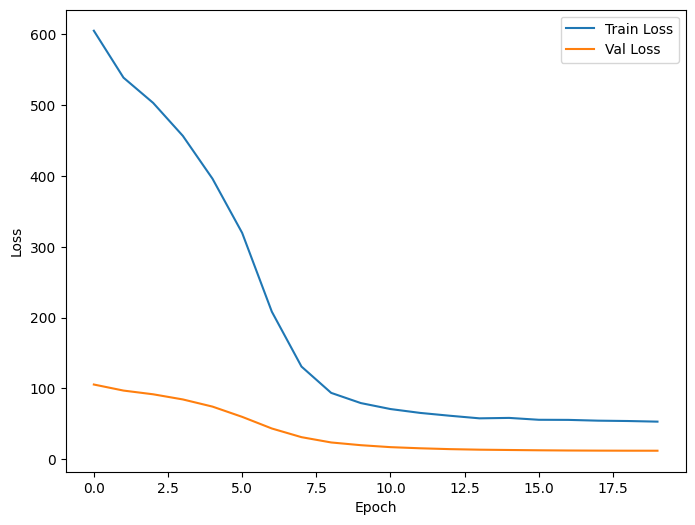

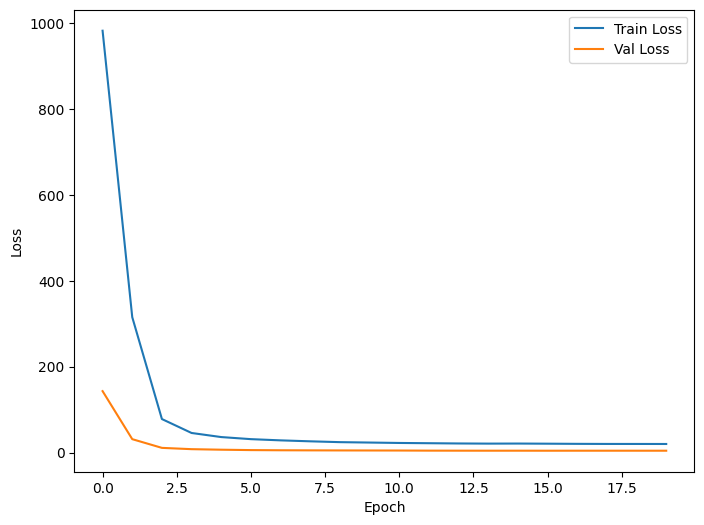

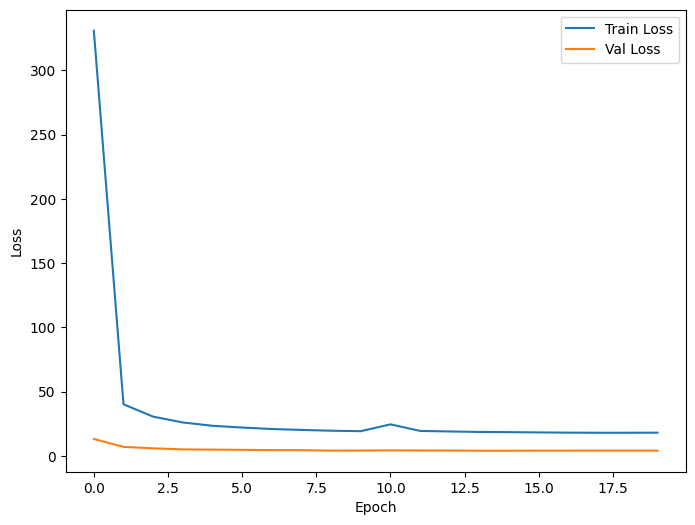

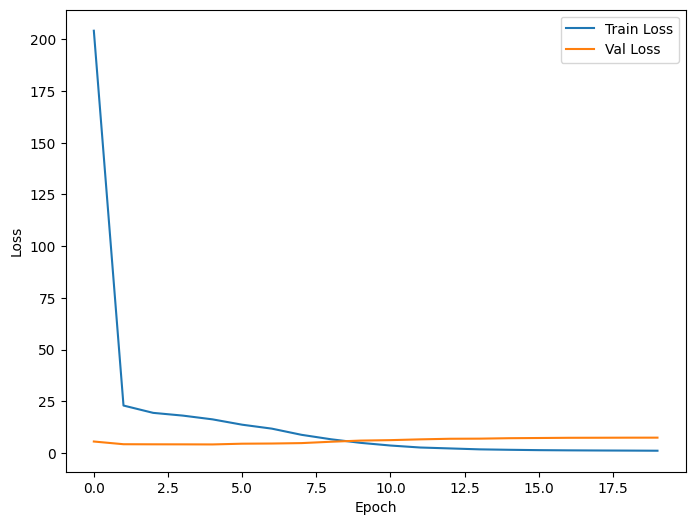

In [23]:
# Loop through each combination in the loss_values list
for i, combo in enumerate(loss_values):
    # Create a new figure and axis
    fig, ax = plt.subplots()

    # Plot the training and validation loss values for the current combination
    ax.plot(combo['train_loss'], label=f"Train Loss")
    ax.plot(combo['val_loss'], label=f"Val Loss")

    # Add axis labels and a legend
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()

    # Save the plot as a file
    fig.savefig(f"plot_{i}.png")

    # Show the plot
    plt.show()
